In [19]:
# Imports
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models, similarities
from gensim.test.utils import datapath
import gensim.models.ldamodel
import gensim
import re
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pysentiment as ps

In [3]:
# parent folder of the documents
parent_folder = ""
# folder to read minutes plain text from
text_folder = "plain_text/"
# folder to save pre-processed minutes in
pre_processed_folder = "pre_processed/"

In [4]:
# download nltk data and make sure they are up-to-date
nltk.download('punkt')
nltk.download('english')
nltk.download('wordnet')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lb4653\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Tokenize and lemmatize the words
def tokenize_and_stem(text):
    text = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    #stemmer = SnowballStemmer("english")
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    pos = nltk.pos_tag(tokens)
    for token in pos:
        if re.search('[a-zA-Z]', token[0]):
            if token[1].startswith('V'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 'v')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            elif token[1].startswith('A'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 'a')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            elif token[1].startswith('R'):
                #token = wordnet_lemmatizer.lemmatize(token[0], 's')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
            else:
                #token = wordnet_lemmatizer.lemmatize(token[0], 'n')
                token = stemmer.stem(token[0])
                filtered_tokens.append(stemmer.stem(token))
    return filtered_tokens

In [6]:
# remove all stop words (english) from a list of tokens
def remove_stopwords(tokens):
    filtered_words = [word for word in tokens if word.lower() not in stop_words]
    return filtered_words

In [7]:
# read in all texts and identify the most common words (number specified in parameter)
from collections import Counter
def get_most_common_words(number = 100):
    word_list = []
    folders = os.listdir(parent_folder + pre_processed_folder)
    for folder in folders:
        files = os.listdir(parent_folder + pre_processed_folder + folder)
        for file in files:
            file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
            content = file_object.read()
            stems = tokenize_and_stem(content)
            words = [word for sent in nltk.sent_tokenize(content) for word in nltk.word_tokenize(sent)]
            words = remove_stopwords(words)
            for word in stems:
                word_list.append(word)
    counts = Counter(word_list)
    most_common_words = []
    for word in counts.most_common(number):
        most_common_words.append(word[0])
    return most_common_words

In [8]:
most_common_words = get_most_common_words(number = 100)

In [9]:
def preprocess_text(text):
    word_list = []
    stems = tokenize_and_stem(text)
    words = remove_stopwords(stems)
    for word in words:
        # Removing hyphens at the beginning and full stops at the end of words
        word = re.sub(re_full_stop, '', word)
        word = re.sub(re_hyphen, '', word)
        # No words containing numbers
        if not re.search(re_numbers, word):
            # remove words shoter than 2 symbols and most common words
            if len(word) > 2 and word not in most_common_words:
                word_list.append(word)
    return word_list

In [10]:
# Perform preparation (tokenization, lemmatization, removing of stop words + most common words) on the dataset
import datetime
re_full_stop = re.compile('\.+$')
re_hyphen = re.compile('^-+.*|-+$')
re_numbers = re.compile('.*[0-9]+.*')
folders = os.listdir(parent_folder + pre_processed_folder)
lemmatized_texts = []
for folder in folders:
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    for file in files:
        date = datetime.datetime(int(file[:4]), int(file[4:6]), int(file[6:8]))
        # Using same time frame like paper (June 1991 - December 2012) for training
        if date >= datetime.datetime(1991, 5, 1) and date <= datetime.datetime(2012, 12, 31):
            file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
            content = file_object.read()
            lemmatized_texts.append(preprocess_text(content))

## Recalculating LDA

In [11]:
# passes: Number of passes through the entire corpus
# chunksize: Number of documents to load into memory at a time and process E step of EM.
# update_every: number of chunks to process prior to moving onto the M step of EM.
dictionary2 = corpora.Dictionary(lemmatized_texts)
dictionary2.filter_extremes(no_below=200, no_above=0.6)
corpus2 = [dictionary2.doc2bow(text) for text in lemmatized_texts]

# Model bereits berechnet und im nächsten Schritt aus dem Speicher geladen
lda2 = models.LdaModel(corpus2, num_topics=8, 
                            id2word=dictionary2, 
                            passes=250, 
                            chunksize=2000,
                            update_every = 1)

In [17]:
model_file = datapath("lda_fomc")
lda2.save(model_file)
#lda2 = models.LdaModel.load(model2_file)

In [12]:
lda2.show_topics(num_words=30)

[(0,
  '0.063*"project" + 0.057*"staff" + 0.050*"forecast" + 0.024*"gdp" + 0.023*"anticip" + 0.021*"direct" + 0.019*"long-run" + 0.018*"dure" + 0.018*"slightli" + 0.017*"consist" + 0.017*"prepar" + 0.017*"restraint" + 0.015*"stabil" + 0.014*"pressur" + 0.014*"unemploy" + 0.014*"sustain" + 0.013*"half" + 0.012*"fourth" + 0.012*"object" + 0.012*"output" + 0.011*"expan" + 0.011*"next" + 0.011*"maintain" + 0.011*"consid" + 0.011*"aggreg" + 0.010*"degr" + 0.010*"greater" + 0.010*"posit" + 0.010*"higher" + 0.010*"core"'),
 (1,
  '0.035*"energi" + 0.035*"employ" + 0.030*"core" + 0.029*"unemploy" + 0.017*"averag" + 0.016*"cost" + 0.015*"food" + 0.014*"rose" + 0.014*"payrol" + 0.014*"compen" + 0.014*"index" + 0.013*"worker" + 0.012*"job" + 0.012*"end" + 0.011*"reflect" + 0.011*"earlier" + 0.011*"first" + 0.011*"privat" + 0.011*"slow" + 0.011*"juli" + 0.011*"april" + 0.010*"gain" + 0.010*"may" + 0.010*"august" + 0.010*"littl" + 0.009*"produc" + 0.009*"februari" + 0.009*"edg" + 0.009*"novemb" + 0

In [14]:
result2 = []
for folder in folders:
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    date = str(folder)[:8]
    
    topic_proportion = [0, 0, 0, 0, 0, 0, 0, 0]
    number_elements = len(files)
    for file in files:
        file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
        content = file_object.read()
        preprocessed_text = preprocess_text(content)
        lda_result = lda2[dictionary2.doc2bow(preprocessed_text)]
        sum = 0
        for i in lda_result:
            sum = sum + i[1]
        for t in lda_result:
            topic_proportion[t[0]] = topic_proportion[t[0]] + t[1] / sum
    topic_proportion = [x / number_elements for x in topic_proportion]
    result2.append([date, topic_proportion])

In [15]:
growth_mandate2 = []
inflation_mandate2 = []
financial_market_mandate2 = []
policy_mandate2 = []
dates = []
for r in result2:
        dates.append(r[0])
        growth_mandate2.append(r[1][0] + r[1][3] + r[1][5] + r[1][6] + r[1][7])
        inflation_mandate2.append(r[1][1])
        financial_market_mandate2.append(r[1][2])
        policy_mandate2.append(r[1][4])

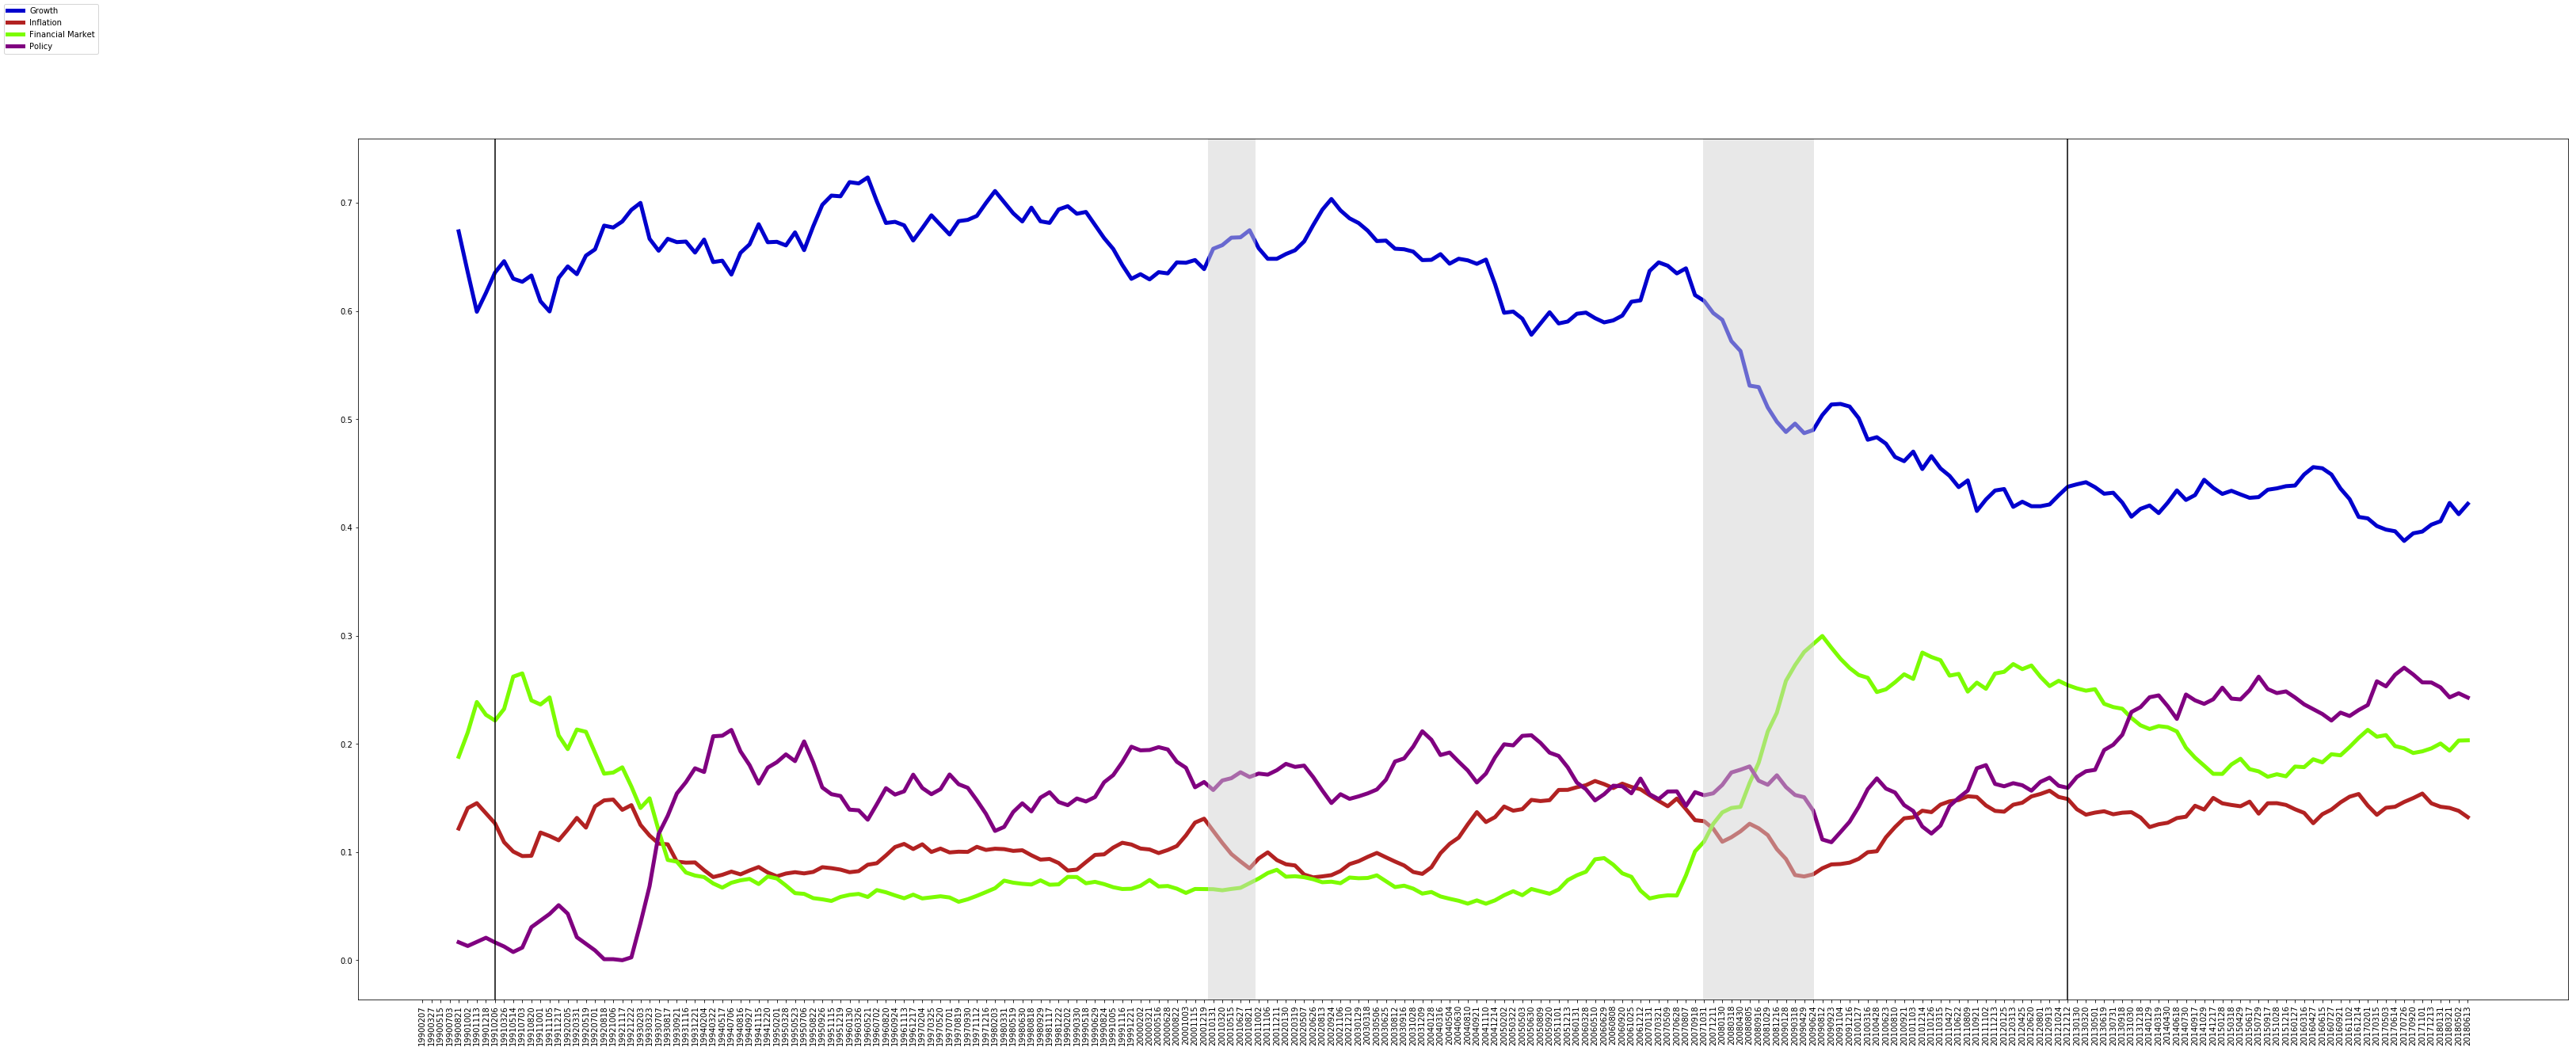

In [16]:
# FOMC Topic Proportions Over Time
import matplotlib
from scipy.interpolate import interp1d
x = dates
y1 = pd.Series.rolling(pd.Series(growth_mandate2), 5).mean()
y2 = pd.Series.rolling(pd.Series(inflation_mandate2), 5).mean()
y3 = pd.Series.rolling(pd.Series(financial_market_mandate2), 5).mean()
y4 = pd.Series.rolling(pd.Series(policy_mandate2), 5).mean()

fig2 = plt.figure(figsize=(50, 20))
ax2 = fig2.add_subplot(111)
ax2.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax2.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax2.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax2.plot(x, y4, color="purple", linewidth=5, label="Policy")

ax2.axvline("20121212", color="black")
ax2.axvline("19910206", color="black")
ax2.axvline("20010515", color="lightgrey", linewidth=60, alpha=0.5)
ax2.axvline("20080916", color="lightgrey", linewidth=140, alpha=0.5)

fig2.legend(loc='upper left', frameon=True)
for ax in fig2.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()

## Extraction of contents

In [20]:
hiv4 = ps.HIV4()

C:\Users\lb4653\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (63,108,109,110,176) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
total_net_tone_scores = []
total_uncertainty_scores = []
for folder in folders:
    score_net_tone_document_level = [0, 0, 0, 0]
    score_uncertainty_document_level = [0, 0, 0, 0]
    files = os.listdir(parent_folder + pre_processed_folder + folder)
    date = str(folder)[:8]
    
    topic_proportion = [0, 0, 0, 0, 0, 0, 0, 0]
    number_elements = len(files)
    for file in files:
        #LDA
        file_object = open(parent_folder + pre_processed_folder + folder + "/"+ file, "r", errors='ignore')
        content = file_object.read()
        preprocessed_text = preprocess_text(content)
        lda_result = lda2[dictionary2.doc2bow(preprocessed_text)]
        sum = 0
        for i in lda_result:
            sum = sum + i[1]
        growth = 0
        inflation = 0
        financial = 0
        policy = 0
        
        for r in lda_result:
            if (r[0] == 0 or r[0] == 3 or r[0] == 5 or r[0] == 6 or r[0] == 7):
                growth = growth + r[1]
            elif r[0] == 1:
                inflation = inflation + r[1]
            elif r[0] == 2:
                financial = financial + r[1]
            else:
                policy = policy + r[1]
        
        # Content Extraction
        tokens = hiv4.tokenize(content)
        score = hiv4.get_score(tokens)
        F = [score['Positive'] - score['Negative'], score['Polarity']]
       
        # Calculating Scores for net tone and uncertainty
        # Reverse tone for inflation mandate
        score_net_tone = [t * F[0] for t in [growth, -inflation, financial, policy]]
        score_uncertainty = [t * F[1] for t in [growth, inflation, financial, policy]]   
        
        
        # Calculating scores at document level
        for i in range(0, 4):
            score_net_tone_document_level[i] = score_net_tone_document_level[i] + score_net_tone[i] / len(tokens)
            score_uncertainty_document_level[i] = score_uncertainty_document_level[i] + score_uncertainty[i] / len(tokens)
            
    # save document scores in lists - each entry is corresponding with one date
    total_net_tone_scores.append(score_net_tone_document_level)
    total_uncertainty_scores.append(score_uncertainty_document_level)

In [22]:
# Normalizing values of net tone scores
net_tone_scores_growth = [t[0] for t in total_net_tone_scores]
growth_mean = np.mean(net_tone_scores_growth)
growth_sd = np.std(net_tone_scores_growth)
net_tone_scores_growth = [(t - growth_mean) / growth_sd for t in net_tone_scores_growth]

net_tone_scores_inflation = [t[1] for t in total_net_tone_scores]
inflation_mean = np.mean(net_tone_scores_inflation)
inflation_sd = np.std(net_tone_scores_inflation)
net_tone_scores_inflation = [(t - inflation_mean) / inflation_sd for t in net_tone_scores_inflation]

net_tone_scores_financial = [t[2] for t in total_net_tone_scores]
financial_mean = np.mean(net_tone_scores_financial)
financial_sd = np.std(net_tone_scores_financial)
net_tone_scores_financial = [(t - financial_mean) / financial_sd for t in net_tone_scores_financial]

net_tone_scores_policy = [t[3] for t in total_net_tone_scores]
policy_mean = np.mean(net_tone_scores_policy)
policy_sd = np.std(net_tone_scores_policy)
net_tone_scores_policy = [(t - policy_mean) / policy_sd for t in net_tone_scores_policy]

In [23]:
# Normalizing values of uncertainty scores
uncertainty_scores_growth = [t[0] for t in total_uncertainty_scores]
growth_mean = np.mean(uncertainty_scores_growth)
growth_sd = np.std(uncertainty_scores_growth)
uncertainty_scores_growth = [(t - growth_mean) / growth_sd for t in uncertainty_scores_growth]

uncertainty_scores_inflation = [t[1] for t in total_uncertainty_scores]
inflation_mean = np.mean(uncertainty_scores_inflation)
inflation_sd = np.std(uncertainty_scores_inflation)
uncertainty_scores_inflation = [(t - inflation_mean) / inflation_sd for t in uncertainty_scores_inflation]

uncertainty_scores_financial = [t[2] for t in total_uncertainty_scores]
financial_mean = np.mean(uncertainty_scores_financial)
financial_sd = np.std(uncertainty_scores_financial)
uncertainty_scores_financial = [(t - financial_mean) / financial_sd for t in uncertainty_scores_financial]

uncertainty_scores_policy = [t[3] for t in total_uncertainty_scores]
policy_mean = np.mean(uncertainty_scores_policy)
policy_sd = np.std(uncertainty_scores_policy)
uncertainty_scores_policy = [(t - policy_mean) / policy_sd for t in uncertainty_scores_policy]

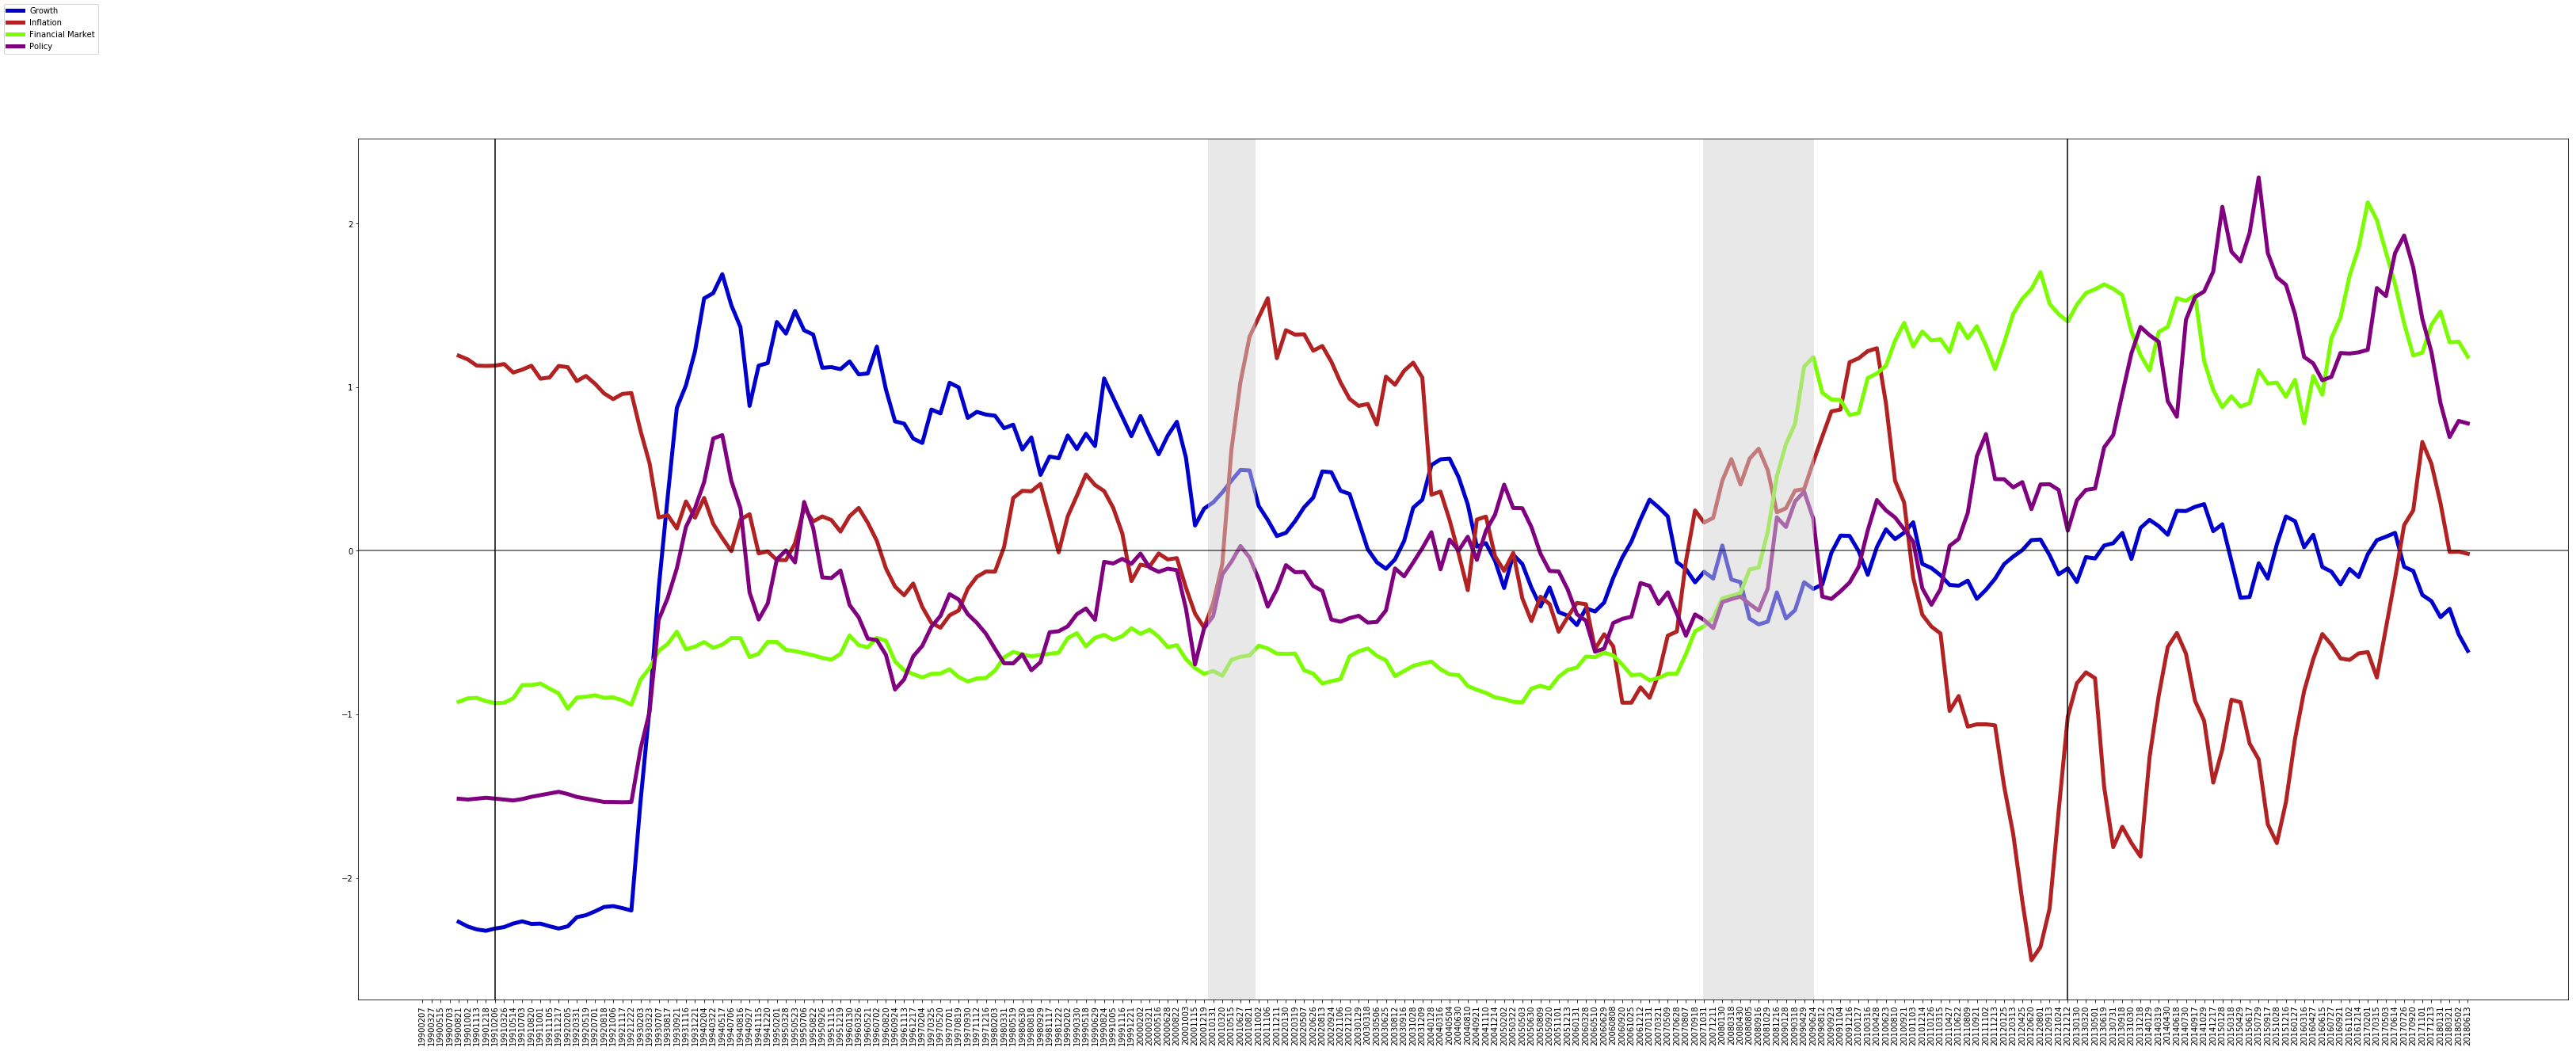

In [24]:
#FOMC Topic Net Tone Scores Over Time

x = dates
y1 = pd.Series.rolling(pd.Series(net_tone_scores_growth), 5).mean()
y2 = pd.Series.rolling(pd.Series(net_tone_scores_inflation), 5).mean()
y3 = pd.Series.rolling(pd.Series(net_tone_scores_financial), 5).mean()
y4 = pd.Series.rolling(pd.Series(net_tone_scores_policy), 5).mean()


fig3 = plt.figure(figsize=(50, 20))
ax3 = fig3.add_subplot(111)
ax3.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax3.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax3.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax3.plot(x, y4, color="purple", linewidth=5, label="Policy")

ax3.axvline("20121212", color="black")
ax3.axvline("19910206", color="black")
ax3.axvline("20010515", color="lightgrey", linewidth=60, alpha=0.5)
ax3.axvline("20080916", color="lightgrey", linewidth=140, alpha=0.5)
ax3.axhline(0, color="black", linewidth=2, alpha=0.5)


fig3.legend(loc='upper left', frameon=True)
for ax in fig3.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()

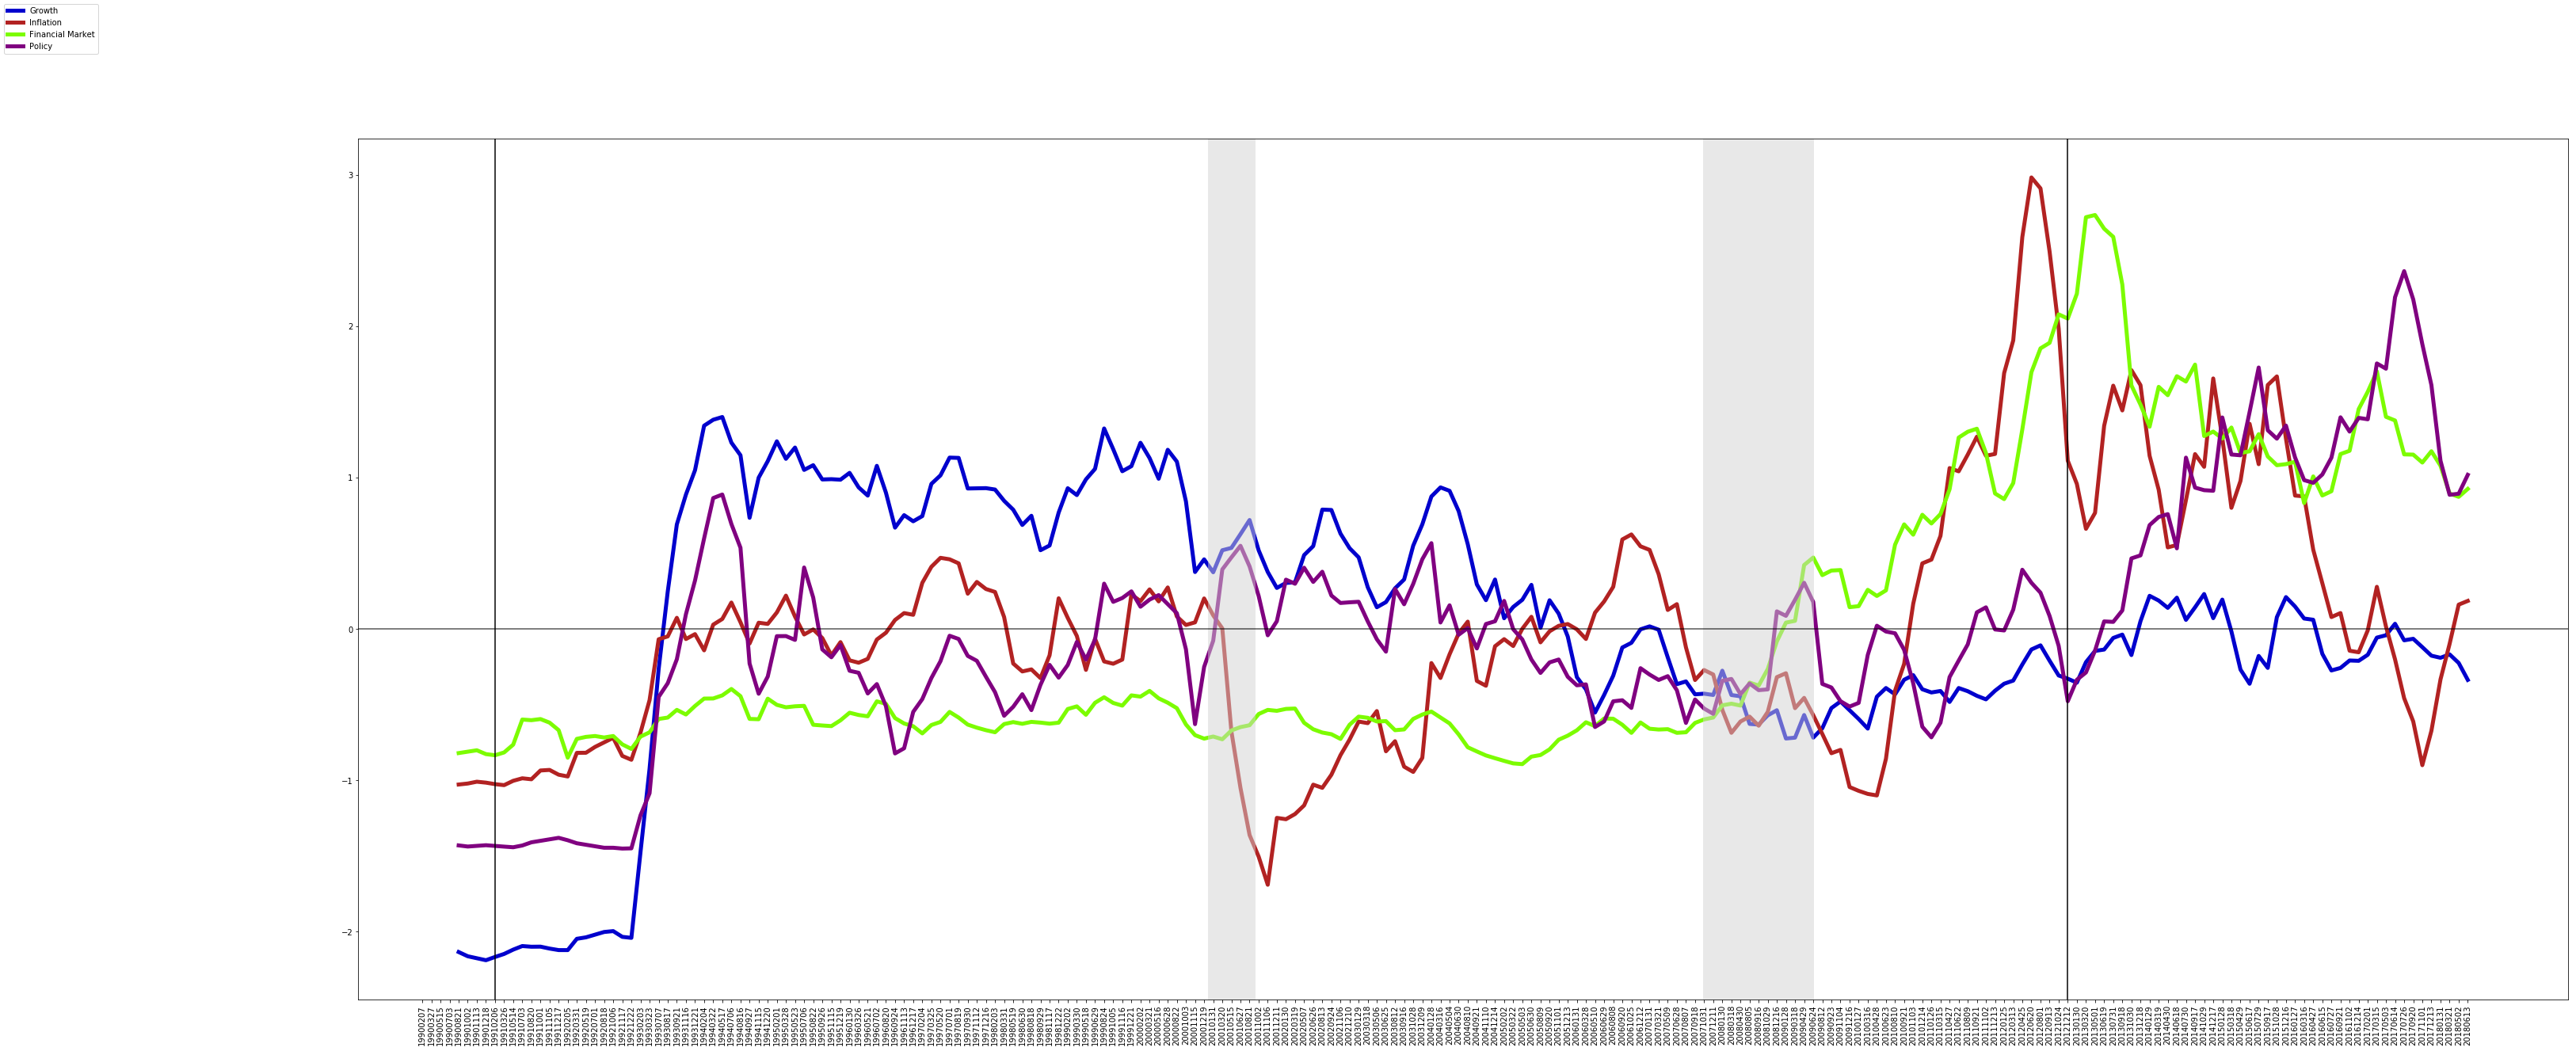

In [25]:
# FOMC Topic Uncertainty Scores Over Time

x = dates
y1 = pd.Series.rolling(pd.Series(uncertainty_scores_growth), 5).mean()
y2 = pd.Series.rolling(pd.Series(uncertainty_scores_inflation), 5).mean()
y3 = pd.Series.rolling(pd.Series(uncertainty_scores_financial), 5).mean()
y4 = pd.Series.rolling(pd.Series(uncertainty_scores_policy), 5).mean()


fig4 = plt.figure(figsize=(50, 20))
ax4 = fig4.add_subplot(111)
ax4.plot(x, y1, color="mediumblue", linewidth=5, label="Growth")
ax4.plot(x, y2, color="firebrick", linewidth=5, label="Inflation")
ax4.plot(x, y3, color="lawngreen", linewidth=5, label="Financial Market")
ax4.plot(x, y4, color="purple", linewidth=5, label="Policy")

ax4.axvline("20121212", color="black")
ax4.axvline("19910206", color="black")
ax4.axvline("20010515", color="lightgrey", linewidth=60, alpha=0.5)
ax4.axvline("20080916", color="lightgrey", linewidth=140, alpha=0.5)
ax4.axhline(0, color="black", linewidth=2, alpha=0.5)


fig4.legend(loc='upper left', frameon=True)
for ax in fig4.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
    plt.xticks()